# Issues

- Analyse method very slow and seems to massively underestimate with MBAR and overestimate with TI. analyse_freenrg in SOMD seems to be much faster and more reliable.
- Indices given by BSS restraint selection scheme do not give the correct atoms in NGLViewer
- Need to pull version of SOMD which works with restraints into GH repo

# <span style="color:teal"> Absolute Binding Free Energies and Experimental Features in BioSimSpace</span>
This is the ABFE (Absolute Binding Free Energy) jupyter notebook for the September 2022 CCPBioSim Workshop. This notebook describes how the functionality of BioSimSpace may be extended using the *sandpit*, and how to set up an absolute binding free energy calculation using the functionality present in the Exscientia sandpit.

It includes core as well as <span style="color:purple">extra</span> options.

##### <span style="color:teal">Required Knowledge</span> 
 - Basic python
 - Part 1 of this workshop (Introduction to Alchemistry with BioSimSpace)
    - This should provide a basic overview of the use of BioSimSpace

##### <span style="color:teal">Learning objectives</span>  
 - Understand how the functionality of BioSimSpace can be extended to include experimental features using the *sandpit*
 - Setup an absolute binding free energy calculation using the functionality present with the Exscientia sandpit

##### <span style="color:teal">Authors</span>  
 - Finlay Clark (@fjclark)

 <span style="color:pink">Further reading </span> references some sections of the [LiveComs Best Practices for Alchemical Free Energy Calculations](https://livecomsjournal.org/index.php/livecoms/article/view/v2i1e18378).

In [19]:
# import libraries
import os
import glob
import csv
import numpy as np
# for the analysis
from alchemlyb.visualisation import plot_mbar_overlap_matrix as _plot_mbar_overlap_matrix
from alchemlyb.visualisation import plot_ti_dhdl as _plot_ti_dhdl
import math
import pandas as pd

# define all the folder locations
main_folder =  os.getcwd()
print(main_folder)
# scripts should be located in:
scripts_folder = f"{main_folder}/scripts"
# other folders
input_dir = f"{main_folder}/inputs"
path_to_ligands = f"{main_folder}/inputs/ligands"

/home/finlayclark/software/devel/bssccpbiosim2022/absolute_binding_free_energies


##### <span style="color:teal">Experimental Features in BioSimSpace</span>

In order to make experimental features available alongside the current development version, BioSimSpace provides a *Sandpit* area. This can be found at `BioSimSpace.Sandpit`. The idea is that new features can be quickly made available while we work on ways to merge them into the main code.

A particular sandpit, S, can be imported as `import BioSimSpace.Sandpit.S as BSS`. Currently there is only one sandpit, belonging to Exscientia. We will be using this today:

In [20]:
import BioSimSpace.Sandpit.Exscientia as BSS

As an example of an experimental feature, we will show how to use the alchemical absolute binding free energy functionality present in `BioSimSpace.Sandpit.Exscientia`, which we are working on in collaboration with Exscientia. This will eventually be merged into the main code.

##### <span style="color:teal">Alchemical Absolute Binding Free Energies: A Quick Reminder</span>

While RBFE calculations can be extremely valuable in drug discovery, several important problems lie outside the scope of RBFE calculations:

- Calculating the RBFEs of structurally dissimilar ligands to a common target
- Calculating RBFEs of the same ligand to the same protein with different binding poses
- Calculating the RBFEs of the same ligand to different targets

Alchemical absolute binding free energy (ABFE) calculations escape these limitations by following a more general thermodynamic cycle in which the ligand’s intermolecular interactions are completely turned off:

<img src="images/abfe_cycle_details.png" width="400"/>

The absolute binding free energy can be obtained by adding up the terms round our free energy cycle, not forgetting any [symmetry corrections](https://aip.scitation.org/doi/full/10.1063/5.0046853) (e.g. if there is more than 1 symmetrical binding site per protein):

\begin{align*}
    \Delta\textit{G}_{\textrm{Bind}}^o
    =&\Delta\textit{G}_{\textrm{Free,\:Discharge}}
    +\Delta\textit{G}_{\textrm{Free,\:Vanish}}
    -\Delta\textit{G}_{\textrm{Release}}^o
    -\Delta\textit{G}_{\textrm{Bound,\:Vanish}}\\
    &-\Delta\textit{G}_{\textrm{Bound,\:Discharge}}
    -\Delta\textit{G}_{\textrm{Bound,\:Restrain}}
    +\Delta\textit{G}_{\textrm{Sym. Corr.}}\\
\end{align*}

The price paid for greater generality is that these calculations are generally harder to converge, as a result of the larger "perturbation" made (complete removal of the ligand).

In some ways ABFE calculations are more simple than RBFE calculations, in that we do not need to align and merge two ligands. However, ABFE calculations require receptor-ligand restraints (these are shown by the red dotted lines above) in order to prevent sampling issues. Among other issues, without restraints the ligand would float away from the binding site as the ligand's intermolecular interactions were removed. In order to obtain converged free energies of binding, we would have to be sure that the ligand was sampling outside the binding site as soon as this became thermodynamically favourable, and that we were correctly estimating the ratios of the sizes of the simulation box to the binding site; in practice, this is not feasible.

Here, we will use a very popular set of receptor-ligand restraints originally proposed by [Boresch et al.](https://pubs.acs.org/doi/full/10.1021/jp0217839) which restrain all 6 external degrees of freedom (three translational and three rotational) of the ligand with respect to the receptor. This is done by imposing harmonic restraints on one distance, two angles, and three dihedral angles defined by three anchor points in the protein (P1-3) and three in the ligand (L1-3):

<img src="images/boresch_dof.png" width="400"/>

It is important to correct for the presence of restraints. Intuitively, we can see that the volume accessible to the non-interacting ligand in state 3 will be different to that accessible in state 4 with the restraints applied, so there must be a free energy change. The standard free energy of releasing the restraint is calculated according to:

\begin{equation*}
\Delta^o\textit{G}_{\text{Release}} = -\textit{k}_\textit{B}\textit{T}\ln{\frac{V^o}{V_L}\frac{8\pi^2}{\xi_L}}
\end{equation*}

Where $V_L$ and $\xi_L$ are the effective translational and rotational volumes for the restrained non-interacting ligand, and $V^o$ is the standard state volume (1660 $\mathrm{\AA}^3$). The use of the standard state volume makes the correction independent of the size of the simulation box.
 
<span style="color:pink">Further reading </span>: 7.1.2

##### <span style="color:teal">Alchemical Absolute Binding Free Energies: Setup in BioSimSpace</span>

Before we start, we emphasise that THIS IS AN EXPERIMENTAL FEATURE and as such is liable to major changes and has not been as thoroughly tested as the standard functionality available through BioSimSpace. Currently, absolute binding free energies are only implemented for GROMACS and SOMD through BioSimSpace. We welcome any feedback on the implementation. 

#### <span style="color:teal">Loading the System</span>

We'll assume that you already have an equilibrated system ready for simulation. For details on how to do this in BioSimSpace, see the [introductory tutorials](https://github.com/michellab/BioSimSpaceTutorials/tree/main/01_introduction). Here, we'll be using the [human macrophage migration inhibitory factor (MIF) / MIF180 complex](https://pubs.acs.org/doi/full/10.1021/acs.jpcb.9b07588):

<img src="images/mif_mif180.png" width="400"/>

<span style="color:purple">Extra:</span> Based on the structure of MIF (a homotrimer), can you think of a correction term that we should include when calculating the absolute binding free energy? What is the value of this correction at 298 K?

The equilibrated input files are available in input/complex.

In [21]:
# load the system
system = BSS.IO.readMolecules(["input/complex/mif_mif180.prm7", "input/complex/mif_mif180.rst7"])

The ligand, MIF180, is the first molecule in the system:

In [22]:
system[0]

<BioSimSpace.Molecule: nAtoms=34, nResidues=1>

We can check the name using the `getResidues` method:

In [23]:
system[0].getResidues()

[<BioSimSpace.Residue: name='LIG', molecule=18577, index=0, nAtoms=34>]

#### <span style="color:teal">Marking the Ligand to be Decoupled</span>

Now, we have to tell BioSimSpace the molecule for which we want to remove the intermolecular interactions, or to "decouple". The function for doing this is stored in the same place as the tools needed to align and merge molecules for RBFE calulations, in `BSS.Align`.

It's important to save the updated status of the molecule using the `updateMolecule` method.

In [24]:
lig = BSS.Align.decouple(system[0])
system.updateMolecule(0,lig)

We can check that our system contains a molecule marked for decoupling:

In [25]:
system.nDecoupledMolecules()

1

And we can extract the decoupled molecule, if required:

In [26]:
decoupled_mol = system.getDecoupledMolecules()
print(decoupled_mol)

[<BioSimSpace.Molecule: nAtoms=34, nResidues=1>]


Note that sometimes "decoupling" is used to refer to the removal of certain intermolecular interactions (Coulombic or Lennard-Jones) while the intramolecular component is retained, but here we will use it in the sense of [Gilson et al.](https://www.sciencedirect.com/science/article/pii/S0006349597787563) to mean removal of at least the intermolecular interactions of the ligand in the presence of restraints.

<span style="color:purple">Extra:</span> By default, BSS.Align.decouple tells BioSimSpace to remove the intramolecular, as well as intermolecular interactions. Repeat the above so that only the intermolecular interactions will be removed. Hint: check the docstring of `decouple`. Note that this option is only valid with GROMACS and has not yet been implemented for SOMD.

#### <span style="color:teal">Selecting the Restraints</span>

The performance of ABFE calculations can be highly dependent on the restraints used. Considering the simulations connecting states 6 and 7 (see cycle above), we would like the restraints to be weak, so that the unrestrained complex is minimally perturbed and convergence is quickly achieved. However, the fastest convergence of the simulations connecting stages 4, 5, and 6 will likely be achieved by using relatively strong restraints to restrict the configurational volume which must be sampled as much as possible. We can strike a compromise between these opposing requirements by selecting the restraints to mimic native protein-ligand interactions as closely as possible, which allows us to find the strongest possible restraints which minimally perturb the unrestrained fully interacting state.

In additino, Boresch restraints have instabilites which are most commonly encountered when any of the contiguous anchor points are close to collinear. This results in large fluctuations in the dihedral angles and the application of large torques through the dihedral restraints - this can "blow-up" the molecular dynamics integrator, causing the simulation to crash. So, we must be careful to avoid such poor selections when choosing our restraint. 

BioSimSpace allows you to select Boresch restraints in an automated way, by running an unrestrained simulation of the fully interacting complex to allow the dynamics of the ligand with respect to the protein to be analysed. This is done using the `BSS.FreeEnergy.RestraintSearch` class, which is used to run and analyse the simulation to generate the restraints:

```Python
protocol = BSS.Protocol.Production(runtime=5*BSS.Units.Time.nanosecond)
restraint_search = BSS.FreeEnergy.RestraintSearch(system, protocol=protocol, engine='gromacs', work_dir='output/restraint_search')
restraint_search.start()
restraint = restraint_search.analyse(method='BSS', block=True)
```

However, given the computational cost of a 5 ns simulation, we've already run a quick simulation (0.5 ns) for you to analyse - see output/restraint_search. We will now use RestraintSearch to analyse the pre-generated trajectory:

No pairs to be evaluated = 1112
% pair: 0.0, % traj = 0.0
% pair: 0.0, % traj = 0.00398406374501992
% pair: 0.0, % traj = 0.00796812749003984
% pair: 0.0, % traj = 0.01195219123505976
% pair: 0.0, % traj = 0.01593625498007968
% pair: 0.0, % traj = 0.0199203187250996
% pair: 0.0, % traj = 0.02390438247011952
% pair: 0.0, % traj = 0.027888446215139442
% pair: 0.0, % traj = 0.03187250996015936
% pair: 0.0, % traj = 0.035856573705179286
% pair: 0.0, % traj = 0.0398406374501992
% pair: 0.0, % traj = 0.043824701195219126
% pair: 0.0, % traj = 0.04780876494023904
% pair: 0.0, % traj = 0.05179282868525897
% pair: 0.0, % traj = 0.055776892430278883
% pair: 0.0, % traj = 0.05976095617529881
% pair: 0.0, % traj = 0.06374501992031872
% pair: 0.0, % traj = 0.06772908366533864
% pair: 0.0, % traj = 0.07171314741035857
% pair: 0.0, % traj = 0.07569721115537849
% pair: 0.0, % traj = 0.0796812749003984
% pair: 0.0, % traj = 0.08366533864541832
% pair: 0.0, % traj = 0.08764940239043825
% pair: 0.0, % tr

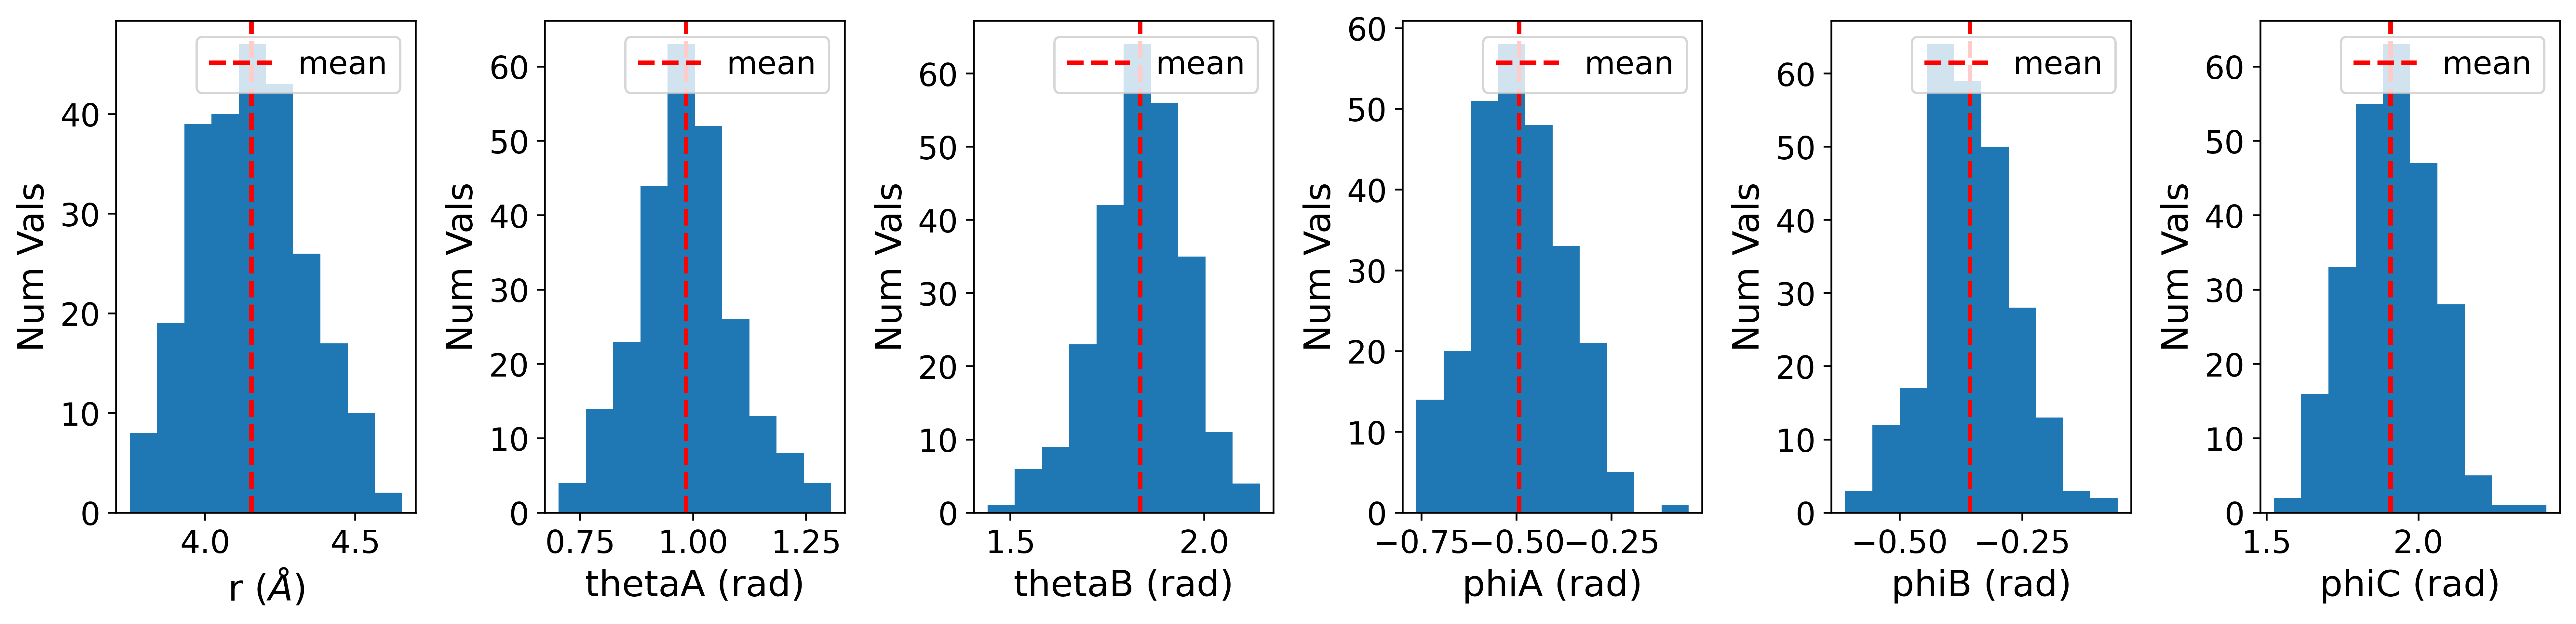

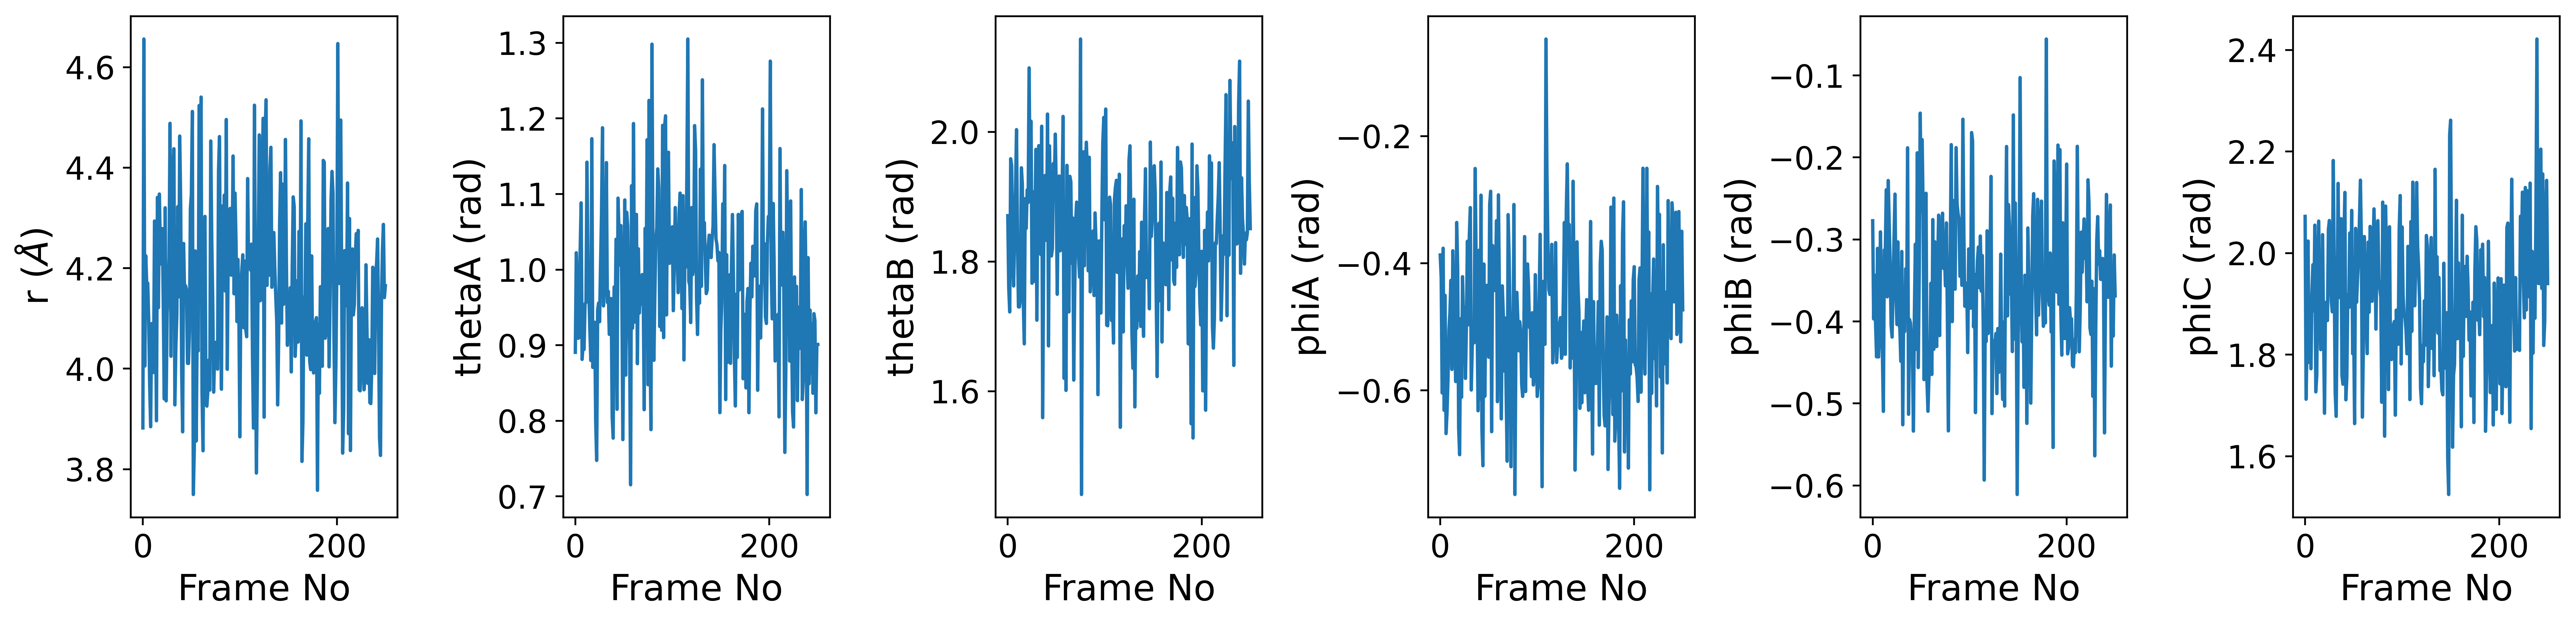

In [41]:
# Load the trajectory
traj = BSS.Trajectory.Trajectory(trajectory="output/restraint_search/gromacs.xtc", topology="input/complex/mif_mif180.prm7")

# Search for the optimal Boresch restraints
from BioSimSpace.Sandpit.Exscientia.Units.Temperature import kelvin
restraint = BSS.FreeEnergy.RestraintSearch.analyse("output/restraint_search", system, traj, 298 * kelvin, method='BSS')

There are two possible methods for selecting the restraints in BioSimSpace - these are:

- "MDRestraintsGenerator": This finds the restraints using the package [MDRestraintsGenerator](https://github.com/IAlibay/MDRestraintsGenerator) written by Irfan Alibay. Also see [this paper](https://chemrxiv.org/engage/chemrxiv/article-details/61f8ef518d70c3340514d25c). Candidate sets of Boresch restraints are generated and the fluctuations of the associated Boresch degrees of freedom are tracked over the unrestrained simulation. The optimum Boresch degrees of freedom are then selected as the set having the lowest total variance, and satisfying certain geometric criteria to ensure stability. The force constants of the restraints are set to some pre-defined value (here 10 kcal mol $\mathrm{^{-1}}$ $\mathrm{\AA^{-2}}$ or kcal mol $\mathrm{^{-1}}$ $\mathrm{rad^{-2}}$).

- "BSS": The inbuilt BioSimSpace method. This was inspired by MDRestraintsGenerator. 

 MDRestraintsGenerator method, which generates candidate sets of Boresch restraints and tracks the fluctuations of the associated Boresch degrees of freedom over the unrestrained simulation. The optimum Boresch degrees of freedom are then selected in a similar way to MDRestraintsGenerator, although the selection is made based on minimum configurational volume accessible to the restrained non-interacting ligand, and the force constants are calculated to mimic the native protein-ligand interactions.

 We've used the BSS method, but feel free to try the MDAnalysis method. It's always a good idea to check the distributions of the Boresch degrees of freedom over the course of the simulations, and where generated, their values against simulation time. Check the output directory to see the plots.

<span style="color:purple">Extra:</span> What issues could arise during the restraint selection stage? How might the plots mentioned above help to diagnose some of these issues?

 The RestraintSearch has returned a restraint object:

In [29]:
type(restraint)

BioSimSpace.Sandpit.Exscientia.FreeEnergy._restraint.Restraint

We can obtain $-\Delta\textit{G}_{\textrm{Release}}^o$ by using the `getCorrection` method:

In [30]:
restraint.getCorrection()

-44.0449 kJ/mol

And we can check the anchor points, force constants, and equilibrium values selected:

In [42]:
restraint._restraint_dict

{'anchor_points': {'r1': <BioSimSpace.Atom: name='CA', molecule=18578 index=17>,
  'r2': <BioSimSpace.Atom: name='N', molecule=18578 index=15>,
  'r3': <BioSimSpace.Atom: name='CB', molecule=18578 index=19>,
  'l1': <BioSimSpace.Atom: name='CAE', molecule=18577 index=3>,
  'l2': <BioSimSpace.Atom: name='CAG', molecule=18577 index=5>,
  'l3': <BioSimSpace.Atom: name='CAP', molecule=18577 index=11>},
 'equilibrium_values': {'r0': 4.1543 A,
  'thetaA0': 0.9842 radians,
  'thetaB0': 1.8347 radians,
  'phiA0': -0.4934 radians,
  'phiB0': -0.3568 radians,
  'phiC0': 1.9079 radians},
 'force_constants': {'kr': 18.5357 M Q-1 T-2,
  'kthetaA': 52.6655 A-2 L2 M Q-1 T-2,
  'kthetaB': 44.7834 A-2 L2 M Q-1 T-2,
  'kphiA': 116.9430 A-2 L2 M Q-1 T-2,
  'kphiB': 186.3190 A-2 L2 M Q-1 T-2,
  'kphiC': 86.0212 A-2 L2 M Q-1 T-2}}

Let's view the anchor atoms to make sure they're sensible. [This page](https://nglviewer.org/ngl/api/manual/usage/selection-language.html) on the NGLViewer selection language may be helpful.

In [33]:
view = BSS.Notebook.View(system)
view.molecule(0)
view.molecules([0,1,2,3])
#FIXME: View the anchor points using NGLViewer. The ligand can be selected with "LIG"
# and indices can be specified with the @id1,idx2,idx3... syntax

NGLWidget(gui_style='ngl')

Do the selected anchor points appear reasonable?

#### <span style="color:teal">Setting Up The Bound Leg Simulations</span>

Now that we have our restraints, we can set up the bound leg simulations. These are managed by `BSS.FreeEnergy.Absolute`. We will need to run three bound leg simulations to account for turning on the restraints, discharging (Coulombic interactions) the ligand, and vanishing (Lennard-Jones interactions) the ligand. Note that the perturbation types required for these stages are "restraint", "discharge_soft", and "vanish_soft", respectively:

In [ ]:
# Set up restraining stage
lam_vals_restrain = [0.000, 0.250, 0.500, 1.000]
restrain_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, lam_vals=lam_vals_restrain, perturbation_type="restraint")
restrain_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, restrain_protocol, engine='gromacs', restraint=restraint, work_dir='output/restrain')
restrain_fe_calc.run()

# Set up discharging stage
lam_vals_discharge = [0.000, 0.143, 0.286, 0.429, 0.571, 0.714, 0.857, 1.000]
discharge_protocol = BSS.Protocol.FreeEnergy(runtime=6*BSS.Units.Time.nanosecond, lam_vals=lam_vals_discharge, perturbation_type="discharge_soft")
discharge_fe_calc = BSS.FreeEnergy.Absolute(restraint.system, discharge_protocol, engine='gromacs', restraint=restraint, work_dir='output/discharge')

Have a look in the `work_dir` for each simulation - all the files needed to run the simulation should have been set up. We could run the simulations using:
```Python
restrain_fe_calc.run()
discharge_fe_calc.run()
```
However, these would take many hours to run, so we'll avoid starting them now.

Now it's your turn: complete the code below to set up the vanish stage calculations for the vanish stage, using SOMD and a 1 fs timestep:

In [ ]:
# Set up the vanish stage
lam_vals_vanish = [0.000, 0.025, 0.050, 0.075, 0.100, 0.125, 0.150, 0.175, 0.200, # We need a lot of these to
                   0.225, 0.250, 0.275, 0.300, 0.325, 0.350, 0.375, 0.400, 0.425, # ensure sufficient overlap
                   0.450, 0.475, 0.500, 0.525, 0.550, 0.575, 0.600, 0.625, 0.650, # between windows!
                   0.675, 0.700, 0.725, 0.750, 0.800, 0.850, 0.900, 0.950, 1.000] 
# FIXME: Complete the code to set up the vanish stage calculations for SOMD with a 1 fs timestep

<span style="color:purple">Extra:</span> Of course, to obtain the overall free energy of binding we must perform the free leg calculations as well, where we discharge and vanish the ligand in a box of water. Set up the free leg simulations using BioSimSpace. You will find the equilibrated input files in input/free_ligand.

#### <span style="color:teal">Analysis</span>

As discussed in the relative binding free energy workshop, you can analyse your data to obtain the potential of mean force along lambda and overlap matrix through BioSimSpace. Normally, this would be done using the `Absolute` object directly:

```Python
restrain_fe_calc.analyse()
```

However, since this is computationally costly, we've provided some sample output for a restraining calculation in output/restrain_pre_run. This can be analysed using the Absolute class:

In [25]:
pmf, overlap = BSS.FreeEnergy.Absolute.analyse("output/restrain_pre_run", estimator="MBAR")

Could not calculate statistical inefficiency.
Running without calculating the statistical inefficiency and without subsampling...


In [26]:
pmf

[(0.0, 0.0000e+00 kcal/mol, 7.3809e-05 kcal/mol),
 (0.125, 0.0233 kcal/mol, 0.0000e+00 kcal/mol),
 (0.25, 0.0427 kcal/mol, 4.5380e-05 kcal/mol),
 (0.375, 0.0595 kcal/mol, 7.8982e-05 kcal/mol),
 (0.5, 0.0743 kcal/mol, 0.0001 kcal/mol),
 (1.0, 0.1212 kcal/mol, 0.0002 kcal/mol)]

`analyse` returns the PMF and (when the estimator is MBAR) the overlap matrix. Plot the PMF with respect to lambda obtained for the restraining simulation.

In [17]:
#FIXME: Plot to PMF with respect to lambda for the pre-run restraining simulations

<span style="color:purple">Extra:</span> Plot the overlap matrix for the pre-run restraining simulations. Was the selection of lambda windows used for the simulation reasonable? 

<span style="color:pink">Further reading </span>: 8.5 (Overlap matrix)

#### <span style="color:teal">Feedback</span>

We hope you've enjoyed your introduction to BioSimSpace! Please let us know if you have any feedback on the sessions or the implementation of BioSimSpace.